# Analysis pipeline for Specificity

## Preliminaries

In [1]:
%cd ~/code/textrec/

/Users/kcarnold/code/textrec


In [2]:
import datetime
import json
import pathlib

import pandas as pd
import numpy as np
import toolz
from IPython.display import Image, HTML

In [3]:
from textrec.paths import paths
from textrec import analysis_util, util, notebook_util, automated_analyses
reload(analysis_util), reload(util), reload(notebook_util), reload(automated_analyses)

Loading COCO captions
Loading COCO id2url
Done


/Users/kcarnold/anaconda3/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Loading ONMT models...
coco_lm_adam_acc_46.00_ppl_16.32_e10_nooptim.pt
Loading model parameters.
coco_cap_adam_acc_48.73_ppl_12.56_e10_nooptim.pt
Loading model parameters.
Ready.
Loading SpaCy...done
Loading COCO captions
Loading COCO id2url
Done
Loading SpaCy...done


(<module 'textrec.analysis_util' from '/Users/kcarnold/code/textrec/src/textrec/analysis_util.py'>,
 <module 'textrec.util' from '/Users/kcarnold/code/textrec/src/textrec/util.py'>,
 <module 'textrec.notebook_util' from '/Users/kcarnold/code/textrec/src/textrec/notebook_util.py'>,
 <module 'textrec.automated_analyses' from '/Users/kcarnold/code/textrec/src/textrec/automated_analyses.py'>)

In [4]:
from textrec.notebook_util import images, id2img, id2url, show_images

In [5]:
# HTML(show_images([images_by_split['val'][0]['cocoid']]))

In [23]:
%matplotlib inline

## Load results of writing experiment

In [79]:
%run -m textrec.batch_analysis

In [80]:
participants = get_participants_by_batch()
participants.keys()

dict_keys(['2018-04-09', '2018-04-24', '2018-04-27', '2018-05-02-invalid', '2018-05-02-old', '2018-05-02'])

In [81]:
batch = '2018-05-02'

In [82]:
len(participants[batch])

25

In [83]:
analyses = analyze_all(participants[batch])

________________________________________________________________________________
[Memory] Calling textrec.analysis_util.get_log_analysis_raw...
get_log_analysis_raw('/Users/kcarnold/code/textrec/logs/jvccx2.jsonl', 1182696, git_rev='c2933d0', analysis_files={ 'analyze.js': '76f95f2156828639ea7c756411b37a4e03cdd403',
  'run-analysis': '11083c5f51c5c469297e930142323920f09fe548',
  'src/Analyzer.js': 'd79a1fdaecf06d56f65bb104d8c00eba820773f1'})
_____________________________________________get_log_analysis_raw - 2.8s, 0.0min
________________________________________________________________________________
[Memory] Calling textrec.analysis_util.get_log_analysis_raw...
get_log_analysis_raw('/Users/kcarnold/code/textrec/logs/36x2r3.jsonl', 930883, git_rev='c651507', analysis_files={ 'analyze.js': '76f95f2156828639ea7c756411b37a4e03cdd403',
  'run-analysis': '11083c5f51c5c469297e930142323920f09fe548',
  'src/Analyzer.js': 'd79a1fdaecf06d56f65bb104d8c00eba820773f1'})
____________________________

_____________________________________________get_log_analysis_raw - 2.4s, 0.0min
________________________________________________________________________________
[Memory] Calling textrec.analysis_util.get_log_analysis_raw...
get_log_analysis_raw('/Users/kcarnold/code/textrec/logs/wf4c3m.jsonl', 1780009, git_rev='25a4b8a', analysis_files={ 'analyze.js': '76f95f2156828639ea7c756411b37a4e03cdd403',
  'run-analysis': '11083c5f51c5c469297e930142323920f09fe548',
  'src/Analyzer.js': 'd79a1fdaecf06d56f65bb104d8c00eba820773f1'})
_____________________________________________get_log_analysis_raw - 2.7s, 0.0min
________________________________________________________________________________
[Memory] Calling textrec.analysis_util.get_log_analysis_raw...
get_log_analysis_raw('/Users/kcarnold/code/textrec/logs/7jcm37.jsonl', 808574, git_rev='25a4b8a', analysis_files={ 'analyze.js': '76f95f2156828639ea7c756411b37a4e03cdd403',
  'run-analysis': '11083c5f51c5c469297e930142323920f09fe548',
  'src/Analyz

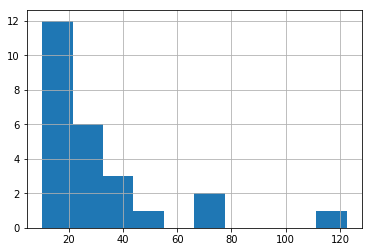

In [60]:
analyses['experiment_level'].total_time.hist()

In [66]:
analyses['experiment_level'].total_time.describe()

count     25.000000
mean      29.823653
std       24.657435
min       10.203233
25%       14.506700
50%       22.852350
75%       33.666833
max      122.433150
Name: total_time, dtype: float64

In [87]:
(trial_level.seconds_spent_typing).describe()

count    216.000000
mean      49.999917
std       39.276310
min        4.398000
25%       28.859750
50%       39.560000
75%       56.145250
max      293.595000
Name: seconds_spent_typing, dtype: float64

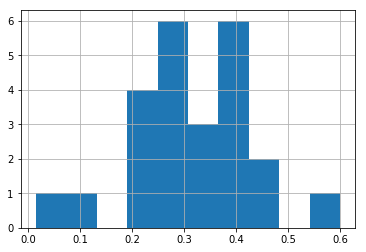

In [73]:
# Fraction of time spent actually typing
((trial_level.groupby('participant').seconds_spent_typing.sum() / 60) / trial_level.groupby('participant').total_time.mean()).hist()

In [61]:
for kind in 'experiment block trial'.split():
    analyses[f'{kind}_level'].to_csv(f'data/analyzed/{kind}_{batch}.csv')

In [62]:
globals().update(analyses)

In [63]:
import seaborn as sns

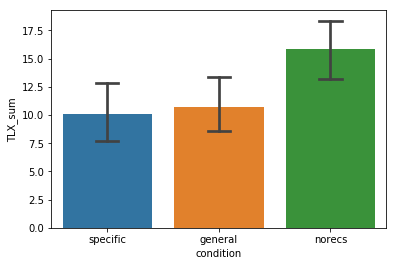

In [64]:
sns.barplot(x='condition', y='TLX_sum', data=block_level, capsize=.2)

In [ ]:
sns.barplot(x='condition', y='text_len', data=trial_level, capsize=.2)

In [ ]:
sns.barplot(x='condition', y='num_tapBackspace', data=trial_level, capsize=.2)

In [ ]:
print('\n\n'.join(x for x in experiment_level_pivot['techDiff'] if x is not None))

In [ ]:
print('\n\n'.join(x for x in experiment_level_pivot['other'] if x is not None))

In [92]:
text = trial_level.text.iloc[-1]
text

'a surfer in the ocean surfing on a wave'

In [91]:
from nltk.corpus import wordnet as wn

In [119]:
[(tok.orth_, tok.lemma_, tok.pos_) for tok in  automated_analyses.nlp(trial_level.text.iloc[5])]

[('a', 'a', 'DET'),
 ('train', 'train', 'NOUN'),
 ('is', 'be', 'VERB'),
 ('traveling', 'travel', 'VERB'),
 ('on', 'on', 'ADP'),
 ('the', 'the', 'DET'),
 ('tracks', 'track', 'NOUN'),
 ('through', 'through', 'ADP'),
 ('a', 'a', 'DET'),
 ('marketplace', 'marketplace', 'NOUN')]

In [125]:
wn.ADJ_SAT

's'

In [123]:
wn.synsets('red', wn.ADJ)

[Synset('red.s.01'), Synset('crimson.s.02'), Synset('crimson.s.03')]

In [129]:
wn.synsets('quickly', wn.ADV)[0].max_depth()

0

In [131]:
wn.synsets?

In [137]:
from nltk import wsd

In [ ]:
wsd.lesk()

In [142]:
import pywsd

Warming up PyWSD (takes ~10 secs)... took 10.516539812088013 secs.


In [149]:
text = trial_level.text.iloc[60]
print(text)
for tok, ss in pywsd.disambiguate(text):
    if ss is not None:
        print(f'{tok:20s} {ss.definition()}')

a red double-decker bus is coming down the street
red                  of a color at the end of the color spectrum (next to orange); resembling the color of blood or cherries or tomatoes or rubies
double-decker        a vehicle carrying many passengers; used for public transport
bus                  a vehicle carrying many passengers; used for public transport
coming               reach or enter a state, relation, condition, use, or position
street               people living or working on the same street


In [139]:
text = trial_level.text.iloc[2]
print(text)
spacy_to_wn = {
    'ADJ': wn.ADJ,
#     'ADV': wn.ADV,
    'NOUN': wn.NOUN,
    'VERB': wn.VERB,    
}
doc = automated_analyses.nlp(text)
toks = [tok.orth_ for tok in doc]
for tok in doc:
    if tok.pos_ not in spacy_to_wn:
        continue
    ss = wsd.lesk(toks, tok.lemma_)
#         for ss in wn.synsets(tok.lemma_, spacy_to_wn[tok.pos_])[:1]:
    print(ss.name(), ss.definition(), ss.max_depth())

a bathroom with a toilet and sink and with a roll of toilet paper on the toilet
bathroom.n.01 a room (as in a residence) containing a bathtub or shower and usually a washbasin and toilet 8
toilet.n.04 the act of dressing and preparing yourself 9
sinkhole.n.01 a depression in the ground communicating with a subterranean passage (especially in limestone) and formed by solution or by collapse of a cavern roof 5
roll.v.17 take the shape of a roll or cylinder 2
toilet.n.04 the act of dressing and preparing yourself 9
paper.n.05 a scholarly article describing the results of observations or stating hypotheses 8
toilet.n.04 the act of dressing and preparing yourself 9


In [141]:
wn.synsets('toilet')

[Synset('toilet.n.01'),
 Synset('toilet.n.02'),
 Synset('gutter.n.02'),
 Synset('toilet.n.04')]

In [133]:
ss.definition()

'the act of dressing and preparing yourself'

In [112]:
ss.name()

'surfer.n.01'

In [99]:
ss=wn.synsets('surfer', wn.NOUN)[0]

In [104]:
ss.hypernyms()

[Synset('swimmer.n.02')]

In [105]:
ss.instance_hypernyms()

[]

In [ ]:
participant_id = participants['2018-05-02'][0]
analyzed = analysis_util.get_log_analysis(participant_id)

In [ ]:
page_data = analyzed['byExpPage']['final-0-0']

In [ ]:
page_data['firstEventTimestamp']

In [ ]:
actions = ['actions']
timestamps = [action['jsTimestamp'] / 1000 for action in actions]
np.diff(timestamps)

In [ ]:
analyzed['screenTimes']

In [ ]:
Counter(action['type'] for action in page_data['actions'])

# Generate nAFC task

For each stimulus image, choose a foil set. It should be about equally difficult for each condition. Simplest approach: find the nearest caption to the concatenation of all captions we got for that image.

TODO: should we be computing similarities of individual captions, rather than complete images?

In [ ]:
cap_vectorizer, caption_vecs = util.get_vectorized_captions()

In [ ]:
caption_vecs.shape

In [ ]:
id2url[570528]

In [ ]:
concat_captions = {stimulus: '\n'.join(toolz.pluck('text', trials))
                   for stimulus, trials in toolz.groupby('stimulus', trial_data).items()}
concat_captions.keys()

In [ ]:
# print(concat_captions[71815])
# print(concat_captions[275449])
print(concat_captions[396295])

For 275449, the foil images are fixated on the 'wine'. But unsurprising, since all but one caption mentions it, and it's probably less common than "cat".

In [ ]:
def get_similar_images(caption, n=10):
    query_vec = cap_vectorizer.transform([caption])
    similarity = caption_vecs.dot(query_vec.T).A.ravel()
    return [images[idx]['cocoid'] for idx in np.argsort(similarity)[-n:][::-1]]
query_caption = concat_captions[396295].replace('wine', '') #trial_data[0]['text']
# query_caption = "a rusty and dirty shower in the bathroom has a tan towel over its handle"
# query_caption = "a sliding glass shower door with a bath mat hanging on it"
query_caption = "a closed shower door with crackled glass encases some hanging colored toiletries"
# print(query_caption)
# HTML(show_images(get_similar_images(query_caption)))

In [ ]:
def get_foil_set(*, stimulus, caption, rs):
    similar_images = get_similar_images(caption, n=10)
    if stimulus not in similar_images:
        print("Inserting", stimulus, 'into foil set')
        similar_images[-1] = stimulus
    rs.shuffle(similar_images)
    return similar_images
stimulus = trial_data[1]['stimulus']
get_foil_set(stimulus=stimulus, caption=concat_captions[stimulus], rs=np.random.RandomState(1234))

In [ ]:
rs = np.random.RandomState(1234)
foil_sets = {
    stimulus: get_foil_set(stimulus=stimulus, caption=concat_captions[stimulus], rs=rs)
    for stimulus in sorted(concat_captions.keys())}

Group tasks so that (1) each annotator never gets the same target image twice and (2) each annotator never sees two captions from the same person. The latter criterion cannot always be met, though, since the number of annotators may not evenly divide the number of participants.

In [ ]:
import random
def shuffled(lst):
    lst = lst[:]
    random.shuffle(lst)
    return lst

In [ ]:
while True:
    trials_by_img = toolz.groupby('stimulus', shuffled(trial_data))
    annotators = []
    while not any(len(trials) == 0 for trials in trials_by_img.values()):
        trials_for_annotator = []
        participants_seen_by_annotator = set()
        for stimulus, trials in trials_by_img.items():
            for i in range(len(trials)):
                participant = trials[i]['participant']
                if participant not in participants_seen_by_annotator:
                    trials_for_annotator.append(trials.pop(i))
                    participants_seen_by_annotator.add(participant)
                    break
            else:
#                 print("Have to use the same participant again")
                trials_for_annotator.append(trials.pop(0))

        annotators.append(shuffled(trials_for_annotator))
    if all(len(set(toolz.pluck('participant', trials))) == len(trials) for trials in annotators):
        break
    assert all(len(trials) == 0 for trials in trials_by_img.values())

In [ ]:
a = annotators[:]

In [ ]:
trials_by_img

Check that each annotator never gets the same target image twice

In [ ]:
assert all(len(set(toolz.pluck('stimulus', trials))) == len(trials) for trials in annotators)

Check that each annotator never sees two captions from the same person.

In [ ]:
assert all(len(set(toolz.pluck('participant', trials))) == len(trials) for trials in annotators)

In [ ]:
[len(trials) for trials in annotators]

In [ ]:
len(annotators)

In [ ]:
def make_task(stimulus, text):
    foil_set = foil_sets[stimulus]
    return dict(
        description=text,
        correct_idx=foil_set.index(stimulus),
        images=[id2url[idx] for idx in foil_set]
    )

In [ ]:
trial = annotators[0][0]
make_task(trial['stimulus'], trial['text'])

In [ ]:
guesses_task = pd.DataFrame([
    json.dumps([make_task(trial['stimulus'], trial['text']) for trial in annotator_trials])
    for annotator_trials in annotators], columns=['task'])
guesses_task.iloc[:1].to_csv(str(paths.data / 'anno-tasks' / 'guesses_test.csv'), index=False)
guesses_task.iloc[1:].to_csv(str(paths.data / 'anno-tasks' / 'guesses_remain.csv'), index=False)
guesses_task.to_csv(str(paths.data / 'anno-tasks' / 'guesses.csv'), index=False)

### Load MTurk results so far

In [ ]:
result_files = list((paths.data / 'mturk').glob('*-guesses.csv'))
batched_guesses_results = (
    pd.concat([pd.read_csv(str(f)) for f in result_files], axis=0, ignore_index=True)
)

In [ ]:
%matplotlib inline

In [ ]:
(batched_guesses_results['WorkTimeInSeconds']/60).hist(bins=30)

In [ ]:
def get_active_dur(results):
    pages = json.loads(results)
    try:
        first_guess = pages[0]['guesses'][0]['timestamp']
        last_guess = pages[-1]['guesses'][-1]['timestamp']
        return (last_guess - first_guess) / 1000 / 60
    except IndexError:
        # Something failed in the UI probably...
        return None
batched_guesses_results['Answer.results'].apply(get_active_dur).hist()
batched_guesses_results['Answer.results'].apply(get_active_dur).describe()
        

In [ ]:
batched_guesses_results[batched_guesses_results['Answer.results'].apply(lambda x: '"guesses":[]' in x)].T

In [ ]:
%debug

In [ ]:
guesses_results = []
for i, row in batched_guesses_results.iterrows():
    for page in json.loads(row['Answer.results']):
#         print(page)
        guess_indices = [guess['idx'] for guess in page['guesses']]
        if len(guess_indices) == 0:
            print("UI fail", row['WorkerId'])
            continue
#         guessed_right_sometime = [row.correctIdx in row.guess_indices for row in mturk_nafc_results.itertuples()]
        stimulus_url = [img for img in page['images'] if img['isCorrect']][0]['url']
        guesses_results.append(dict(
            guesser=row['WorkerId'],
            description=page['description'],
            num_guesses=len(guess_indices),
            stimulus_url=stimulus_url))
pd.DataFrame(guesses_results)

In [ ]:
num_responses_by_caption = mturk_nafc_results.groupby('Answer.description').size().to_dict()

### Generate tasks remaining

In [ ]:
# trials_todo = [trial for trial in trial_data if num_responses_by_caption.get(trial['text'], 0) < 3]
# len(trial_data), len(trials_todo)

In [ ]:
# i = 0
# while True:
#     out_fn = paths.data / 'anno-tasks' / f'{datetime.date.today().isoformat()}-{i}-nAFC.csv'
#     if not out_fn.exists():
#         break
#     i += 1
# out_fn

In [ ]:
# rs = np.random.RandomState(1234)
# pd.DataFrame([make_task(trial, rs) for trial in trials_todo]).to_csv(out_fn, index=False)

### Generate the actual HIT text...

In [ ]:
from jinja2 import Template
html = Template(open(paths.top_level / 'HITs' / '2018-05-04-image-description-match.jinja.html').read()).render(dict(
    description='${description}',
    images=['${image_%d_url}' % i for i in range(10)]))

In [ ]:
html2 = html
trial = trial_data[18+7*9]
for k, v in make_task(trial['stimulus'], trial['text']).items():
    html2 = html2.replace('${' + k + '}', str(v))
HTML('<div style="height: 1000px; position: relative;">'+html2+'</div>')
# print(html2)

In [ ]:
import subprocess
subprocess.Popen('pbcopy', stdin=subprocess.PIPE).communicate(html.encode('utf-8'))

# Analyze MTurk results

In [ ]:
mturk_nafc_results.groupby('Answer.description').num_guesses.mean().to_dict()

In [ ]:
%matplotlib inline

In [ ]:
(mturk_nafc_results['WorkTimeInSeconds'][mturk_nafc_results['WorkTimeInSeconds'] < 5*60] / 60).hist(bins=30)

In [ ]:
np.median(mturk_nafc_results['WorkTimeInSeconds'] / 60) * 9/60

In [ ]:
(
    15 # participants
    * 3 # conditions per participant
    * 3 # captions per condition
    - 1 # image not shown
) * 3 # annotators per description


In [ ]:
    * .24 # reward per annotator
) * 1.2 # MTurk 20% fee

Did the same worker see the same target image multiple times?

In [ ]:
next(data.iterrows())[1]['Input.image_0_url']

In [ ]:
mturk_nafc_results['target_image_url'] = [row['Input.image_'+str(row['correctIdx'])+"_url"] for _, row in mturk_nafc_results.iterrows()]

In [ ]:
bad_worker_image_pairs = set()
for worker_id, data in mturk_nafc_results.groupby('WorkerId'):
    target_images = [row['target_image_url'] for _, row in data.iterrows()]
    if len(target_images) != len(set(target_images)):
#         print(worker_id)
        value_counts = pd.Series(target_images).value_counts()
        value_counts = value_counts[value_counts > 1]
#         print(value_counts)
        for img in value_counts.index:
            bad_worker_image_pairs.add((worker_id, img))
bad_worker_image_pairs

annotation_row_is_bad = [
    (row['WorkerId'], row['target_image_url']) in bad_worker_image_pairs
    for _, row in mturk_nafc_results.iterrows()
]
mturk_nafc_results['row_is_bad'] = annotation_row_is_bad

In [ ]:
mturk_nafc_results['row_is_bad'].mean()

In [ ]:
guess_results = mturk_nafc_results[~mturk_nafc_results['row_is_bad']].rename(columns={'Answer.description': 'text'})

In [ ]:
len(mturk_nafc_results)

In [ ]:
len(guess_results), len(trial_data)

In [ ]:
trial_data

In [ ]:
annotator_level_data = pd.merge(
    pd.DataFrame(trial_data).rename(columns={'participant': 'writer'}),
    guess_results.rename(columns={'WorkerId': 'guesser'}).drop(['HITId', 'HITTypeId', 'Title', 'Description', 'Keywords', 'RequesterAnnotation', 'guesses'], axis=1),
    on='text', validate='1:m', how='right')
annotator_level_data
    #.groupby().num_guesses.mean().to_frame('mean_num_guesses'),
#     left_on='text', right_index=True).groupby('condition').mean_num_guesses.aggregate(['mean', 'std'])

In [ ]:
guesses_results[0]

In [ ]:
annotator_level_data = pd.merge(
    pd.DataFrame(trial_data).rename(columns={'participant': 'writer'}),
    pd.DataFrame(guesses_results).rename(columns={'description': 'text'}),
    on='text', validate='1:m', how='right')
annotator_level_data
    #.groupby().num_guesses.mean().to_frame('mean_num_guesses'),
#     left_on='text', right_index=True).groupby('condition').mean_num_guesses.aggregate(['mean', 'std'])

In [ ]:
annotator_level_data.columns

In [ ]:
annotator_level_data.to_csv('annotator_level_data_2018-05-22v2.csv', index=False)

In [ ]:
(annotator_level_data['num_guesses'] == 1).mean()

In [ ]:
%pwd

In [ ]:
%load_ext rpy2.ipython

In [ ]:
%%R
library(lme4)
library(ggplot2)

In [ ]:
%%R -i annotator_level_data
(model = lmer(num_guesses ~ condition + (1|writer) + (1|guesser) + (1|stimulus), annotator_level_data))

In [ ]:
%%R -i annotator_level_data
(null_model = lmer(num_guesses ~ (1|writer) + (1|guesser) + (1|stimulus), annotator_level_data))

In [ ]:
%%R
library(pbkrtest)

In [ ]:
%%R
(kr <- KRmodcomp(model, null_model))

In [ ]:
%%R -i annotator_level_data
(glm.full = glmer(num_guesses ~ condition + (1|writer) + (1+guesser) + (1|stimulus), annotator_level_data, family=poisson()))

In [ ]:
%%R
(glm.null = glmer(num_guesses ~ (1|writer) + (1+guesser) + (1|stimulus), annotator_level_data, family=poisson()))

In [ ]:
%%R
#confint(glm.full)

In [ ]:
%%R
anova(glm.full, glm.null, test="Chisq")

In [ ]:
%%R -i annotator_level_data
(nb_model = glmer.nb(num_guesses ~ condition + (1|writer) + (1+guesser) + (1|stimulus), annotator_level_data))

In [ ]:
%%R -i annotator_level_data
(nb_model.null = glmer.nb(num_guesses ~ (1|writer) + (1+guesser) + (1|stimulus), annotator_level_data))

In [ ]:
%%R
anova(nb_model, nb_model.null, test="Chisq")

In [ ]:
results = pd.DataFrame([dict(trial, specificity=specificity_lookup[trial['text'].strip()]) for trial in trial_data])
for col in ['condition', 'participant']:
    results[col] = results[col].astype('category')
results.info()

In [ ]:
results.groupby('condition').specificity.mean()

In [ ]:
pd.DataFrame(trial_data).sample(frac=1.0).sort_values('stimulus').to_csv('trial_data_by_stimulus.csv')

# How many images does this caption apply to?

In [ ]:
data = pd.read_csv("/Users/kcarnold/Downloads/Submitted Captions - Sheet1.csv").iloc[:,:6]

In [ ]:
data

In [ ]:
data.shape

In [ ]:
data = data.dropna().copy()
data.shape

In [ ]:
data['is_unique'] = (data.iloc[:,5] == '1')
data.is_unique.mean()

In [ ]:
data.groupby(['block', 'idx_in_block', 'condition']).is_unique.mean()

In [ ]:
data['participant'] = data['participant'].astype('category')
data['condition'] = data['condition'].astype('category')

In [ ]:
data.groupby('condition').is_unique.mean()

In [ ]:
%%R -i data
transformed <- art(is_unique ~ condition + (1|participant), data=data)
summary(transformed)
anova(transformed)

In [ ]:
example = trial_data[-1]['text']
example

Concepts: traffic light. COCO doesn't have "pedestian crossing sign". There are 4330 images with traffic lights in them in COCO. That's way too much. Looking at Visual Genome.

Visual Genome synsets are potentially best, but they're sometimes inaccurate. e.g., "18 wheeler" is "cyclist.n.01". So let's consider an object a match if matches either the synset or object name.

In [ ]:
vg_base = pathlib.Path('/Data/VisualGenome')
image_objects = json.load(open(vg_base / 'objects.json'))

In [ ]:
img_by_id = {img['image_id']: img for img in image_objects}

In [ ]:
obj_synsets = json.load(open(vg_base / 'object_synsets.json'))

In [ ]:
obj_attributes = json.load(open(vg_base / 'attributes.json'))

In [ ]:
len(obj_attributes), len(image_objects)

In [ ]:
obj_attributes[0].keys()

In [ ]:
attributes_by_img = {att['image_id']: att['attributes'] for att in obj_attributes}

In [ ]:
attributes_by_img[61514]

In [ ]:
# def has_object(obj_name):
#     return {
#         img['image_id'] for img in image_objects
#         if any(obj_name in '\n'.join(obj['names']) for obj in img['objects'])
#            }
def has_object(imgid, obj_name):
    return any(obj_name in '\n'.join(obj['names']) for obj in attributes_by_img[imgid])

In [ ]:
# def has_synset(obj_synset):
#     return {
#         img['image_id'] for img in image_objects
#         if any(obj_synset in obj['synsets'] for obj in img['objects'])}
def has_synset(imgid, obj_synset):
    return any(obj_synset in obj['synsets'] for obj in attributes_by_img[imgid])

In [ ]:
def has_obj_with_attr(imgid, obj_name, attr):
    return any(
        (obj_name in '\n'.join(obj['names'])) and (attr in obj.get('attributes', []))
        for obj in attributes_by_img[imgid])

def has_synset_with_attr(imgid, obj_synset, attr):
    return any(
        (obj_synset in obj['synsets']) and (attr in obj.get('attributes', []))
        for obj in attributes_by_img[imgid])

def has_obj_without_attr(imgid, obj_name, attr):
    return any(
        (obj_name in '\n'.join(obj['names'])) and (attr not in obj.get('attributes', []))
        for obj in attributes_by_img[imgid])

def has_synset_without_attr(imgid, obj_synset, attr):
    return any(
        (obj_synset in obj['synsets']) and (attr not in obj.get('attributes', []))
        for obj in attributes_by_img[imgid])

In [ ]:
obj_synsets['pedestrian sign']

In [ ]:
# candidates = (
#     (has_object('pedestrian sign') | has_object('pedestrian crossing sign') | has_object('crossing sign') | has_object('sign')) &
#     (has_object('traffic light') | has_synset('traffic_light.n.01'))
# )
candidates = {
    imgid for imgid in attributes_by_img.keys()
    if (
        (
            has_object(imgid, 'pedestrian sign') |
            has_object(imgid, 'pedestrian crossing sign') |
            has_object(imgid, 'crossing sign') |
            has_obj_with_attr(imgid, 'sign', 'yellow')
        ) & (
            has_obj_without_attr(imgid, 'traffic light', 'red') |
            has_synset_without_attr(imgid, 'traffic_light.n.01', 'red')
        ))}
len(candidates)

In [ ]:
show_images(candidates)

In [ ]:
[img['image_id'] for img in image_objects if '61514' in img.get('image_url', '')]
#Image(img_by_id[61514]['image_url'])

In [ ]:
img_by_id[61514]

# Measuring Specificity

We use paired comparisons to analyze specificity and accuracy. For a target image $x$ and a fixed set of imposter images $Y$, the **specific accuracy** of a caption is the fraction of comparisons that chose $x$. 

We start with our dataset of paired comparisons.

In [ ]:
captions = [
    "exactly how are both the dog and the person going to fit on that skateboard?",
    "the dark haired dog is trying to ride on the skateboard.",
    "a person in shorts and a black dog both have one foot on a skateboard.",
    "a dog with a black head and black legs and ears standing up has one black paw on a black skateboard with white wheels and a guy with black and white shoes and white socks has one foot on the skateboard also and there are bikes and other people in the background"
]

In [ ]:
alternatives = 'dog-and-guy-on-skateboard just-dog-on-skateboard guy-on-skateboard-holding-dog dog-and-guy-next-to-skateboard'.split()
target = alternatives[0]
imposters = alternatives[1:]
applies_to = [
    'dog-and-guy-on-skateboard dog-and-guy-next-to-skateboard'.split(),
    'just-dog-on-skateboard'.split(),
    'dog-and-guy-on-skateboard'.split(),
    'dog-and-guy-on-skateboard just-dog-on-skateboard guy-on-skateboard-holding-dog dog-and-guy-next-to-skateboard'.split()
]
applies_to = {cap: tgts for cap, tgts in zip(captions, applies_to)}
applies_to

In [ ]:
import random
random.seed(0)
pairs = [[target, imposter] for imposter in imposters]
for pair in pairs:
    random.shuffle(pair)
pairs

In [ ]:
def fake_answer_pairs_for_caption(applies, pairs):
    outcomes = []
    for a, b in pairs:
        choices = []
        if a in applies:
            choices.append(0)
        if b in applies:
            choices.append(1)
        if len(choices) == 0:
            choices = [0, 1]
        outcomes.append(random.choice(choices))
    return outcomes
fake_answer_pairs_for_caption(applies_to[captions[0]], pairs)

In [ ]:
fake_comparisons_data = []
for caption in captions:
    for annotator in range(5):
        for pair, outcome in zip(pairs, fake_answer_pairs_for_caption(applies_to[caption], pairs)):
            picked = pair[outcome]
            fake_comparisons_data.append(dict(
                caption=caption,
                annotator=annotator,
                pair=pair,
                picked=picked))

In [ ]:
data = pd.DataFrame(fake_comparisons_data)
len(data)

In [ ]:
data['picked_correct'] = data['picked'] == 'dog-and-guy-on-skateboard'
data.groupby('caption').picked_correct.mean().sort_values()

# Final analyses

We find a main effect of writing condition on outcome specificity.

In [ ]:
%load_ext rpy2.ipython

In [ ]:
results = pd.DataFrame([
    dict(participant_id=participant_id, condition=condition)
    for participant_id in 'abc def ghi'.split() for condition in 'general specific norecs'.split()
])
results['participant_id'] = results['participant_id'].astype('category')
results['condition'] = results['condition'].astype('category')
results['specificity'] = np.random.randn(len(results))

In [ ]:
%%R
#install.packages("ARTool")
library(ARTool)

In [ ]:
%%R -i results
summary(results)

In [ ]:
%%R -i results
transformed <- art(specificity ~ condition + (1|participant), data=results)
summary(transformed)
anova(transformed)